In [1]:
from droidlet.perception.robot import LabelPropagate
import os
import json
import sys
if "/opt/ros/kinetic/lib/python2.7/dist-packages" in sys.path:
    sys.path.remove("/opt/ros/kinetic/lib/python2.7/dist-packages")
import cv2
import numpy as np

In [2]:
root = '/checkpoint/apratik/finals/default/apartment_0/'

def make_data(root, img_indx):
    src_img = cv2.imread(os.path.join(root, "rgb/{:05d}.jpg".format(img_indx)))
    src_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx)))
    src_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx)))
    with open(os.path.join(root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]
    cur_pose = base_pose_data["{}".format(img_indx+1)]
    cur_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx+1)))
    print(f'{type(src_img), type(src_depth), type(src_label)}')
    # Visualize label
    return src_img, src_depth, src_label, src_pose, cur_pose, cur_depth
    
src_img, src_depth, src_label, src_pose, cur_pose, cur_depth = make_data(root, 1)

(<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>)


In [3]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

from utils import d3_40_colors_rgb

def display_sample(semantic1, semantic2):
    
    arr = []
    for semantic_obs in [semantic1, semantic2]:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)

    titles = ['src', 'propagated']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 2, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

In [4]:
x = LabelPropagate()

In [5]:
label = x(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

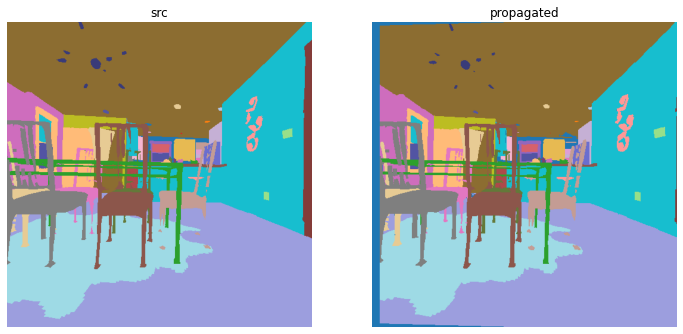

In [6]:
display_sample(src_label, label)

In [7]:
print('src_img shape', src_img.shape)
print('src_depth shape', src_depth.shape)
print('src_label shape', src_label.shape)
print('src_pose', src_pose)
print('cur_pose', cur_pose)
print('cur_depth', cur_depth.shape)
print(label)
print(np.unique(label))
print(np.unique(src_label))

# label, src_img, src_depth, src_label, src_pose, cur_pose, cur_depth

src_img shape (512, 512, 3)
src_depth shape (512, 512)
src_label shape (512, 512)
src_pose [-0.0, -0.0, 0.06806784709170054]
cur_pose [-0.0, -0.0, 0.09424779310719465]
cur_depth (512, 512)
[[ 0.  0.  0. ... 58. 58. 58.]
 [ 0.  0.  0. ... 58. 58. 58.]
 [ 0.  0.  0. ... 58. 58. 58.]
 ...
 [ 0.  0.  0. ... 23. 23. 23.]
 [ 0.  0.  0. ... 23. 23. 23.]
 [ 0.  0.  0. ... 23. 23. 23.]]
[  0.   4.  23.  39.  40.  41.  42.  43.  58.  59.  60.  89.  90.  94.
  98. 132. 170. 184. 190. 191. 209. 218. 221. 233. 240. 243. 261. 262.
 269. 275. 285. 292. 308. 311. 312. 314. 318. 326. 333. 336. 338. 348.
 351. 365. 367. 399. 407. 411. 424. 435. 436. 438. 443. 444. 448. 449.
 451. 452. 454. 458. 461.]
[  4  23  39  40  41  42  43  58  59  60  89  90  94  98 132 170 184 190
 191 209 218 221 233 240 243 261 262 269 275 285 292 308 311 312 314 318
 326 333 336 338 348 351 365 367 399 407 411 424 435 436 438 443 444 448
 449 451 452 454 458 461]


In [8]:
u = np.unique(src_label)
print(u)
u0 = np.where(label == u[0], 1, 0)
print(np.unique(u0, return_counts=True))

[  4  23  39  40  41  42  43  58  59  60  89  90  94  98 132 170 184 190
 191 209 218 221 233 240 243 261 262 269 275 285 292 308 311 312 314 318
 326 333 336 338 348 351 365 367 399 407 411 424 435 436 438 443 444 448
 449 451 452 454 458 461]
(array([0, 1]), array([257887,   4257]))


In [11]:
rsrc_img = np.load("src_img.npy")
rsrc_depth = np.load("src_depth.npy")
rsrc_pose = np.load("src_pose.npy")
rsrc_label = np.load("src_label.npy")
rcur_depth = np.load("cur_depth.npy")
rcur_pose = np.load("cur_pose.npy")
results = np.load("res_labels.npy")
print('src_img shape', rsrc_img.shape)
print('src_depth shape', rsrc_depth.shape)
print('src_label shape', rsrc_label.shape)
print('src_pose', rsrc_pose)
print('cur_pose', rcur_pose)
print('cur_depth', rcur_depth.shape)
print(np.unique(results, return_counts=True))

src_img shape (512, 512, 3)
src_depth shape (512, 512, 3)
src_label shape (512, 512)
src_pose [-4.47034836e-08  0.00000000e+00  3.00000137e-01]
cur_pose [-4.47034836e-08  0.00000000e+00  1.78813920e-07]
cur_depth (512, 512, 3)
(array([0., 1.]), array([261341,    803]))
